In [1]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np

# Utilities

## Points and Distances

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## PlotMap

In [3]:
def label(i):
    return (label(i//26-1)+chr(65+i%26)) if i>25 else chr(65+i)

In [4]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=3,
            styleP='b-o', lwP=2, msP=3,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, labels=False, scale=False):

    V, E = G

    def round_down(x, level): return (x//level)*level
    def round_up(x, level): return (x//level+1)*level
    
    xmin = round_down(min([ x for (x, _) in V ]), 100)
    xmax = round_up(max([ x for (x, _) in V ]), 100)
    ymin = round_down(min([ y for (_, y) in V ]), 100)
    ymax = round_up(max([ y for (_, y) in V ]), 100)
    dx = xmax-xmin
    dy = ymax-ymin
    yoffset = (ymax-ymin)//10
    
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin-yoffset, ymax)
    
    if not grid:
        plt.axis('off')

    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    if scale:
        # plot 1000m scale
        ybar = ymin-0.9*yoffset
        D = [ (xmin, ybar+50), (xmin, ybar), (xmin+1000, ybar), (xmin+1000, ybar+50) ]
        plt.plot( [ d[0] for d in D ], [ d[1] for d in D ], 'k-', lw=0.5)
        plt.text(xmin+500, ymin-0.7*yoffset, '1000m' , horizontalalignment='center', size=8)
    
    if labels:
        for i in range(len(V)):
            x, y = V[i]
            plt.text(x+0.0150*dx, y-0.0350*dy, label(i), size=8)
        
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
        
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(xmax, ymin-0.7*yoffset, text, horizontalalignment='right', size=8)
    if grid:
        plt.grid()
    plt.show()

## Add Targets

In [5]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Generate Central Warehouse Location

In [6]:
from statistics import median

def generateWarehouseLocation(M):
    V, _ = M
    xc = median([ x for (x, y) in V ])
    yc = median([ y for (x, y) in V ])
    cloc = (xc, yc)
    minloc = V[0]
    mindist = dist(minloc, cloc)
    for i in range(1, len(V)):
        d = dist(V[i], cloc)
        if d<mindist:
            minloc = V[i]
            mindist = dist(V[i], cloc)
    return minloc

## Generate Delivery Data

In [7]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

# Finding the Shortest Path

## The Algorithm

This is the $A^{*}$ algorithm introduced in Week 3.

In [8]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [9]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

## Testing

In [10]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [11]:
W = generateWarehouseLocation(M)

In [12]:
A = C[0]
B = C[-1]

In [13]:
MAB = addTargets(M, [A, B])

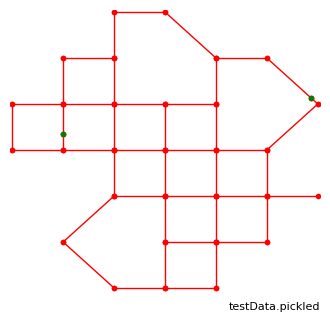

In [14]:
plotMap(MAB, T=[A, B] ,text="testData.pickled")

In [15]:
P = shortestPath(MAB, A, B)

In [16]:
P

[(2200, 4901),
 (2200, 4500),
 (3350, 4500),
 (4500, 4500),
 (5650, 4500),
 (6800, 4500),
 (7950, 5650),
 (7794, 5805)]

In [17]:
pathLength(P)

6846

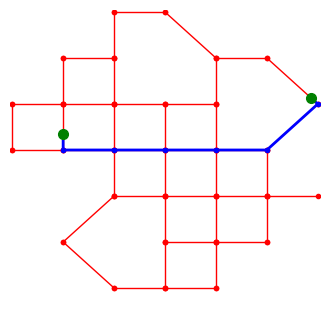

In [18]:
plotMap(MAB, T=[A, B], P=P)

# Finding Short Delivery Route

## Greedy Algorithm

In [19]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [20]:
def createLoopG(M, T, plot=False, timing=False):

    def makeLoop(V, P, L):
        loop = []
        for i in range(len(L)-1):
            sub = P[V.index(L[i])][V.index(L[i+1])]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()

    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    # D, P = createTables(M, T)   # note these are the distances between all vertices in M (and T)
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:2]+[T[0]]
        T = T[2:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):  
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            if plot:
                print('-'.join([ label(V.index(l)) for l in L ]))
                loop = makeLoop(V, P, L)
                plotMap(M, T=L, P=loop, w=W, labels=True, 
                        text=f"{len(L):d} steps {pathLength(loop):,d}m")
                
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(V, P, L)

## Testing Greedy Algorithm

In [21]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [22]:
W = generateWarehouseLocation(M)

In [23]:
random.seed(0)
T = random.sample(C, k=len(C)//2)

In [24]:
MC = addTargets(M, T)

P-AH-AE-P


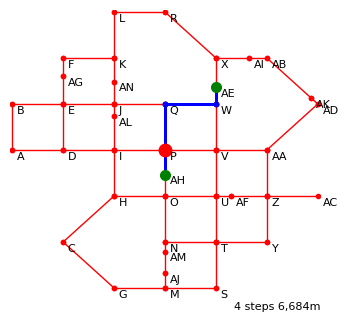

P-AH-AF-AE-P


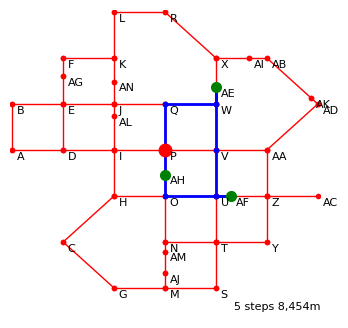

P-AH-AF-AE-AL-P


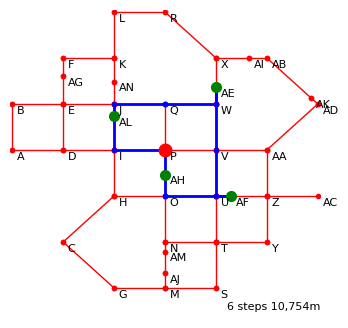

P-AH-AF-AE-AN-AL-P


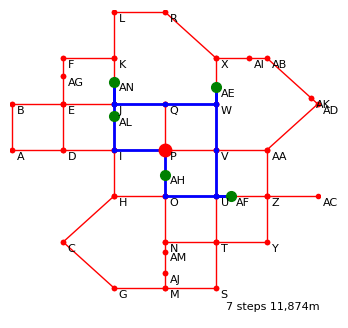

P-AH-AM-AF-AE-AN-AL-P


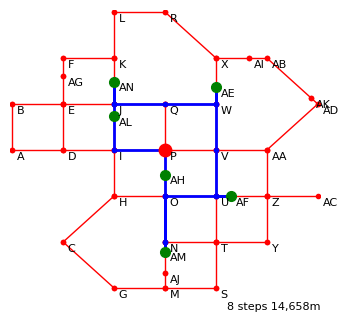

P-AH-AJ-AM-AF-AE-AN-AL-P


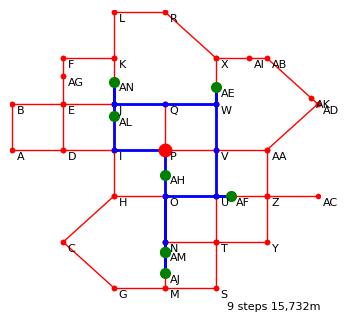

P-AH-AJ-AM-AF-AI-AE-AN-AL-P


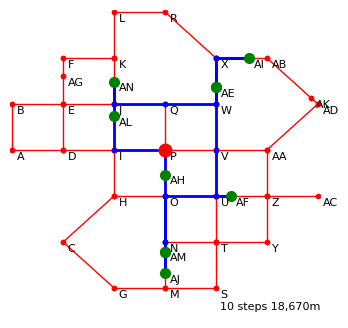

P-AH-AJ-AM-AF-AK-AI-AE-AN-AL-P


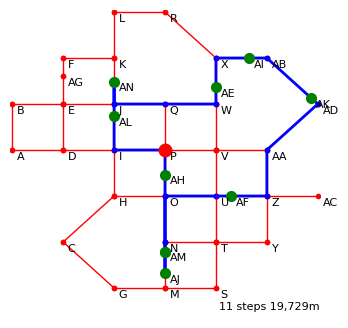

P-AH-AJ-AM-AF-AK-AI-AE-AG-AN-AL-P


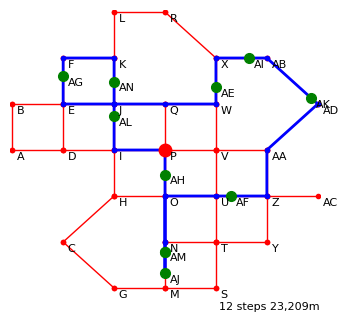

In [25]:
PG = createLoopG(MC, [W]+T, plot=True)

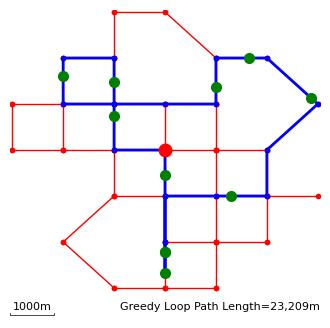

In [26]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Greedy Loop Path Length={pathLength(PG):3,d}m")

## Statistic of Greedy Delivery Path Length

In [27]:
import statistics

def simulateGreedyPathLength(p, M, C, days=10, seed=0, log=False):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoopG(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Greedy Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    plt.show()

In [28]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [29]:
W = generateWarehouseLocation(M)

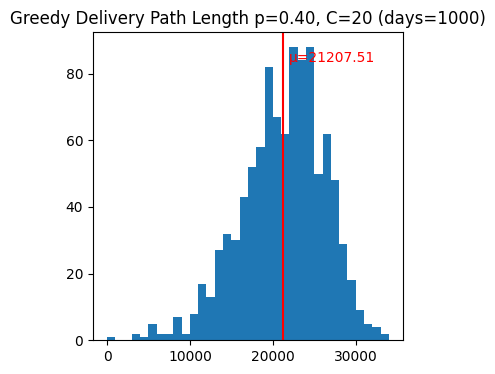

In [30]:
simulateGreedyPathLength(0.4, M, C, days=1000)

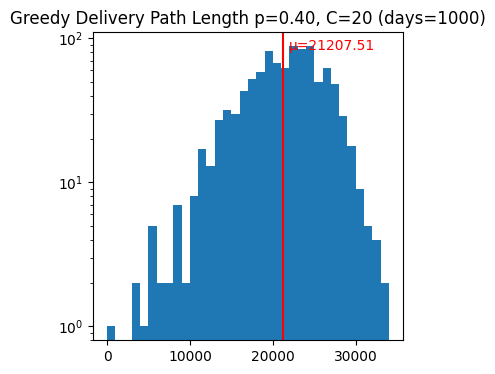

In [31]:
simulateGreedyPathLength(0.4, M, C, days=1000, log=True)

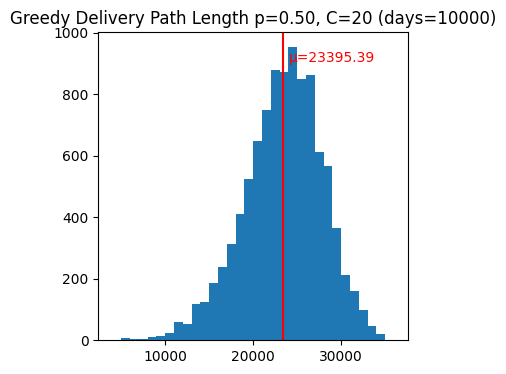

In [32]:
simulateGreedyPathLength(0.5, M, C, days=10000)

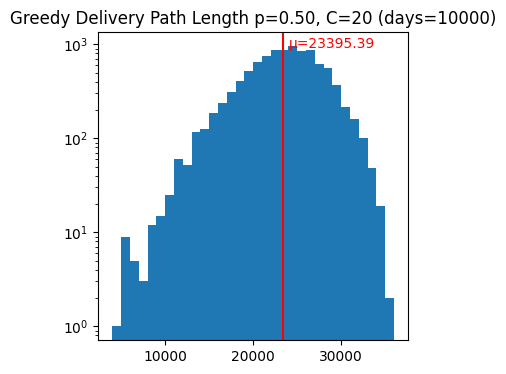

In [33]:
simulateGreedyPathLength(0.5, M, C, days=10000,log=True)

# Finding Optimal Delivery Path

## Iterative Integer Programming

In [34]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [35]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [36]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
                
    def cycles(k, n):
        if k==1:
            return [ [i] for i in range(0,n) ]
        else:
            sc=cycles(k-1, n)
            all=[]
            for c in sc:
                for i in range(0,n):
                    if c.count(i)==0:
                        all.append(c+[i])
            return all

    for k in range(3, 4):   
        cycs=cycles(k,n)
        for c in cycs:
            c.append(c[0])
            prob+=pulp.lpSum([ x[c[i]][c[i+1]] for i in range(0,k)]) <= k-1
            constraints += 1    
            
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0, timeLimit=2)
    res = prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
                
        res = prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## Testing

In [37]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [38]:
W = generateWarehouseLocation(M)

In [39]:
random.seed(0)
T = random.sample(C, k=len(C)//2)

In [40]:
MC = addTargets(M, T)

In [41]:
P = createLoop(MC, [W]+T)

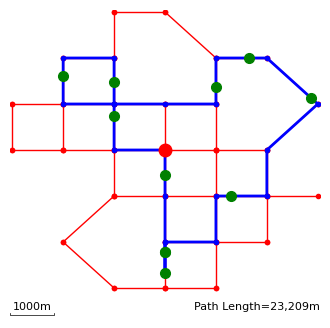

In [42]:
plotMap(MC, T=T, w=W, P=P, scale=True, text=f"Path Length={pathLength(P):3,d}m")

Comparing with the optimal delivery route with the result of the greedy algorithm:

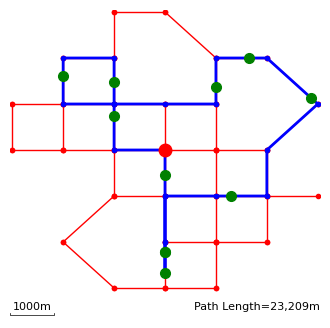

In [43]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Path Length={pathLength(PG):3,d}m")

## Statistic of Delivery Path Length

In [44]:
import statistics

def simulateOptimalPathLength(p, M, C, days=10, seed=0, log=False):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoop(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Optimal Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    plt.show()

In [45]:
D = generateDeliveries(0.4, len(C), days=10)
for d in D:
    print(d)

[9, 10, 11, 13, 16]
[1, 6, 6, 10, 14, 16, 16]
[3, 11, 13, 15]
[1, 3, 5, 6, 9, 11]
[0, 4, 9, 12, 15, 16, 18]
[2, 6, 8, 8, 12, 12, 13, 15, 17]
[1, 10, 12, 16, 19]
[1, 2, 10, 13]
[0, 2, 5, 7, 9, 10, 12, 15, 16, 16, 19]
[0, 1, 3, 4, 8, 15, 19]


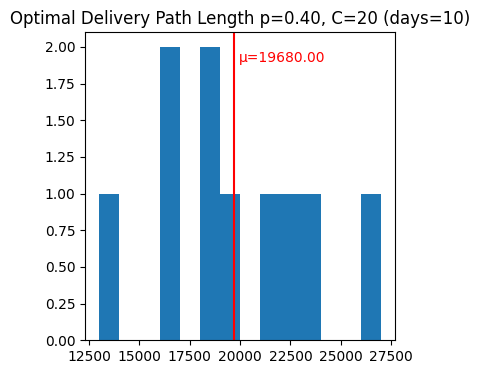

In [46]:
simulateOptimalPathLength(0.4, M, C, days=10)

# Path Planning for Full Data

In [47]:
import pickle
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [48]:
W = generateWarehouseLocation(M)

In [49]:
len(C)

100

In [50]:
D = generateDeliveries(0.2, len(C), days=10)
for d in D:
    print(d)

[14, 19, 20, 42, 47, 47, 50, 54, 55, 57, 64, 80, 89, 95]
[8, 13, 16, 17, 25, 32, 40, 42, 48, 48, 52, 59, 64, 68, 76, 79, 85, 85, 85, 93, 95, 96, 97, 97]
[1, 19, 25, 41, 46, 48, 50, 51, 56, 60, 60, 61, 63, 67, 68, 75, 81, 81, 97, 98]
[4, 12, 16, 21, 22, 25, 26, 26, 31, 39, 44, 50, 51, 52, 56, 58, 60, 61, 64, 70, 77, 83, 98, 99]
[1, 3, 5, 10, 20, 23, 24, 34, 35, 45, 50, 57, 64, 66, 77, 77, 81, 96]
[4, 9, 15, 15, 17, 19, 55, 58, 59, 59, 60, 62, 63, 70, 73, 73, 90, 92, 93, 93]
[5, 14, 17, 24, 31, 50, 51, 51, 54, 57, 61, 66, 68, 93, 94, 97, 97]
[1, 2, 35, 38, 40, 42, 42, 51, 58, 69, 76, 76, 81, 85, 89, 92]
[7, 8, 9, 14, 15, 18, 25, 38, 39, 40, 45, 56, 67, 67, 70, 72, 75, 83, 93, 94, 96]
[0, 2, 9, 13, 23, 29, 32, 40, 44, 44, 52, 62, 64, 66, 68, 72, 82, 96, 97]


Day 0:


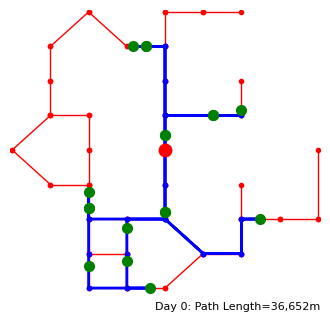

Day 1:


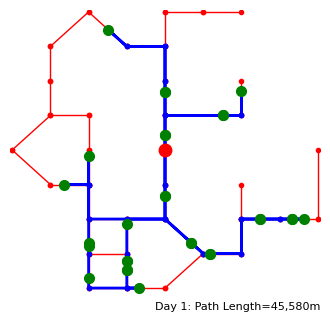

Day 2:


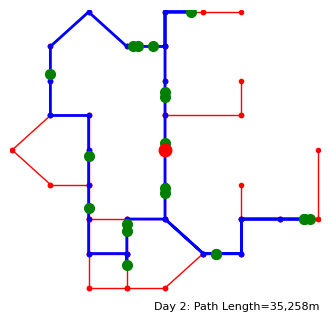

Day 3:


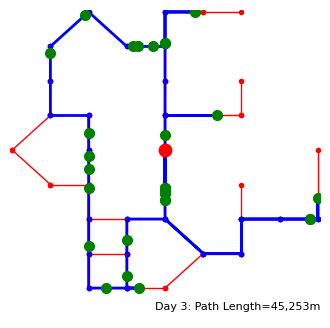

Day 4:


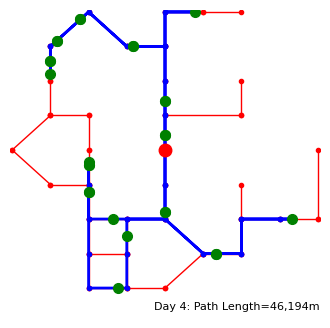

Day 5:


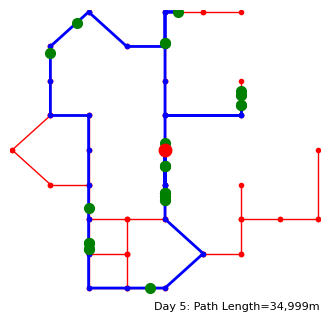

Day 6:


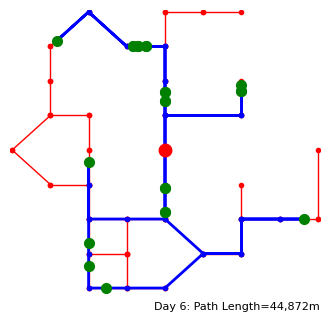

Day 7:


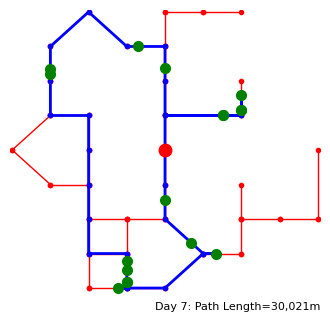

Day 8:


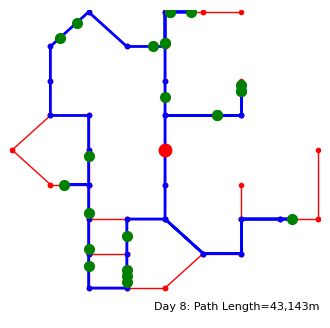

Day 9:


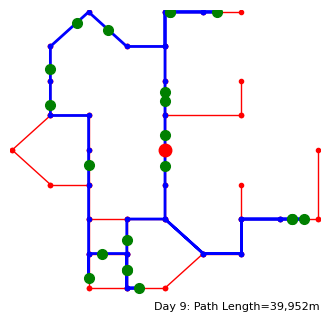

In [51]:
length = []
for d in range(len(D)):
    print(f"Day {d}:")
    T = [ C[c] for c in set(D[d]) ]
    MT = addTargets(M, T)
    P = createLoopG(MT, [W]+T)
    length.append(pathLength(P))
    plotMap(MT, T=T, w=W, P=P, text=f"Day {d}: Path Length={pathLength(P):3,d}m")

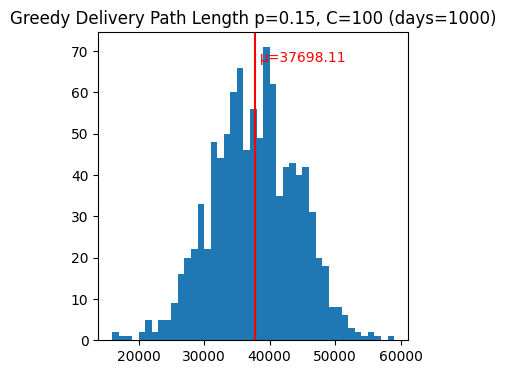

In [52]:
simulateGreedyPathLength(0.15, M, C, days=1000)

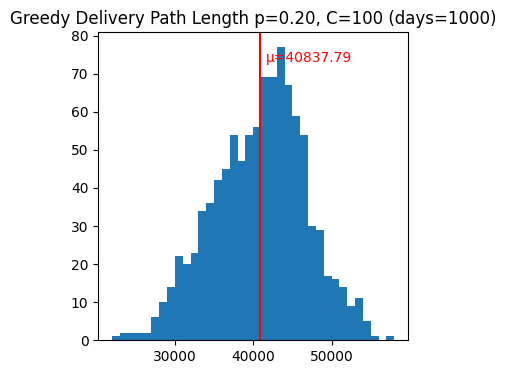

In [53]:
simulateGreedyPathLength(0.2, M, C, days=1000)

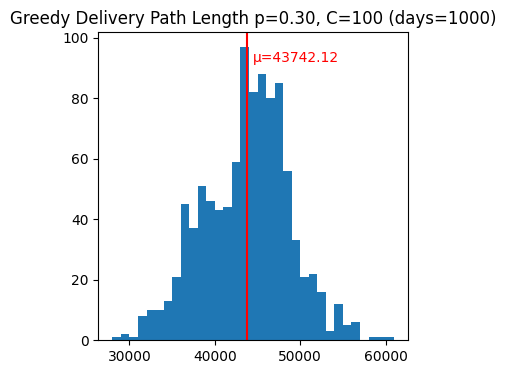

In [54]:
simulateGreedyPathLength(0.3, M, C, days=1000)

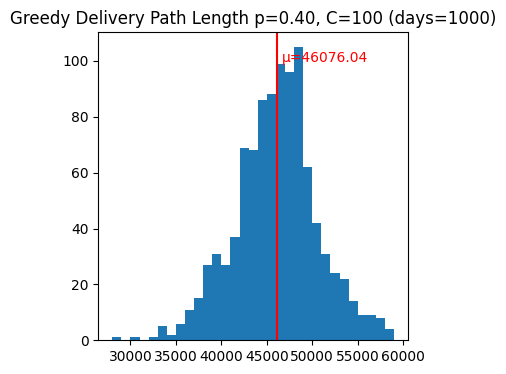

In [55]:
simulateGreedyPathLength(0.4, M, C, days=1000)